# **Exploratory Data Analysis**: Transaction Fraud Detection

### Carina Carino

### 02/17/2024

Analyze the transaction data to engineer features. Below is the list of questions your supervisor would like you to analyze. For every question, provide figures and tables supporting your response, and explain how your findings will influence how you would design your features, the fraud detection model, or the overall system. Report your findings (analysis and design decisions) in a jupyter notebook.


# Libraries:

In [59]:
!pip install pandas 
!pip install numpy 
!pip install scikit-learn 
!pip install seaborn
!pip install statsmodels




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
import statsmodels.api as sm



import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision", 2)

# Data Integration:

In [61]:
# Read the csv file. Make sure to set the first column and first row as index
data = pd.read_csv('../transactions.csv', header=[0], index_col=[0])

# displaying the first five rows of the dataset
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,sex,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0


# Quick overview of the dataset

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   sex                    object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int64(5)

Notice the features are a mix of numerical and categorical features. Let's look at the statistical information of the numerical features:

In [63]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06,1.85e+06
mean,4.17e+17,7.01e+01,4.88e+04,3.85e+01,-9.02e+01,8.86e+04,1.36e+09,3.85e+01,-9.02e+01,5.21e-03
std,1.31e+18,1.59e+02,2.69e+04,5.07e+00,1.37e+01,3.01e+05,1.82e+07,5.11e+00,1.38e+01,7.20e-02
min,6.04e+10,1.00e+00,1.26e+03,2.00e+01,-1.66e+02,2.30e+01,1.33e+09,1.90e+01,-1.67e+02,0.00e+00
25%,1.80e+14,9.64e+00,2.62e+04,3.47e+01,-9.68e+01,7.41e+02,1.34e+09,3.47e+01,-9.69e+01,0.00e+00
50%,3.52e+15,4.75e+01,4.82e+04,3.94e+01,-8.75e+01,2.44e+03,1.36e+09,3.94e+01,-8.74e+01,0.00e+00
75%,4.64e+15,8.31e+01,7.20e+04,4.19e+01,-8.02e+01,2.03e+04,1.37e+09,4.20e+01,-8.02e+01,0.00e+00
max,4.99e+18,2.89e+04,9.99e+04,6.67e+01,-6.80e+01,2.91e+06,1.39e+09,6.75e+01,-6.70e+01,1.00e+00


By looking at the mean amount of the numerical features, we can see that some of these features are 'large' and needs to be scaled. Now let's check for missing values:

In [64]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
sex                      0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


All columns are populated. We do not have to worry about removing or imputing data.

# Q1: What is the distribution between fraudulent and non-fraudulent transactions?
Reference: https://www.pythoncharts.com/matplotlib/pie-chart-matplotlib/

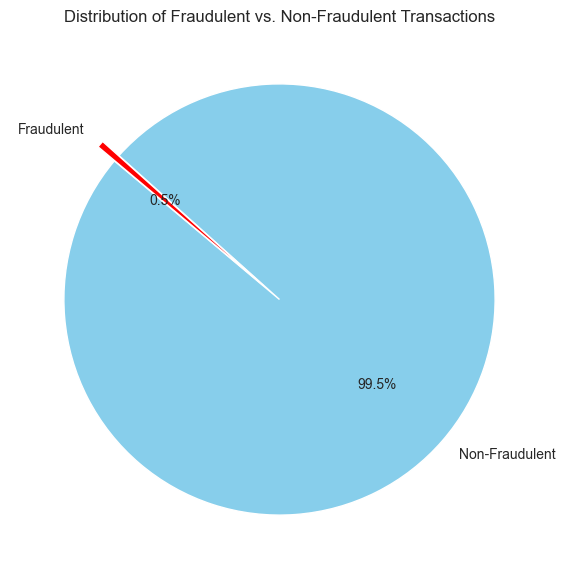

In [65]:
fraud_counts = data['is_fraud'].value_counts()
import matplotlib.pyplot as plt

# Labels for the classes
labels = ['Non-Fraudulent', 'Fraudulent']

# Colors for each section
colors = ['Skyblue','Red']

# Explode the 2nd slice (i.e., 'Fraudulent')
explode = (0, 0.1)  # only "explode" the 2nd slice

# Create pie chart
plt.figure(figsize=(7, 7))
plt.pie(fraud_counts, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()


The figure above visualizes the distribution of fraudulent versus non-fraudulent transactions.It reveals that majority, 99.48%, of the transactions are non-fraudulent while only 0.52% of the transactions are fraudulent. This highlights the challenge of detecting fraudulent activities against predominantly legitimate transactions. Consequently, the stark contrast between the two categories emphasizes the need for analytical and machine learning techniques to identify fraud within such imbalanced dataset. O

Meaning we might have to explore class balancing techniques and use the appropriate evaluation metrics.



# Q2: Which age groups are more susceptible to fraudulent transactions?

In [66]:
# Convert 'trans_date_trans_time' to pandas datetime object
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# We only need the date, note that this code converts it back to object so we have to convert it again to datetime object
data['trans_date'] = data['trans_date_trans_time'].dt.date
data['trans_date'] = pd.to_datetime(data['trans_date'])

# Lets check
data['trans_date'].head()

0   2019-01-01
1   2019-01-01
2   2019-01-01
3   2019-01-01
4   2019-01-01
Name: trans_date, dtype: datetime64[ns]

In [67]:
# We also need to convert 'dob' to pandas datetime object
data['dob'] = pd.to_datetime(data['dob'])
# Lets check
data['dob'].head()

0   1988-03-09
1   1978-06-21
2   1962-01-19
3   1967-01-12
4   1986-03-28
Name: dob, dtype: datetime64[ns]

In [68]:
# Calculate the age of the customers at the time of the transaction
data['age_at_transaction'] = data['trans_date'].apply(lambda x: x.year) - data['dob'].dt.year
data['age_at_transaction'].head()

0    31
1    41
2    57
3    52
4    33
Name: age_at_transaction, dtype: int64

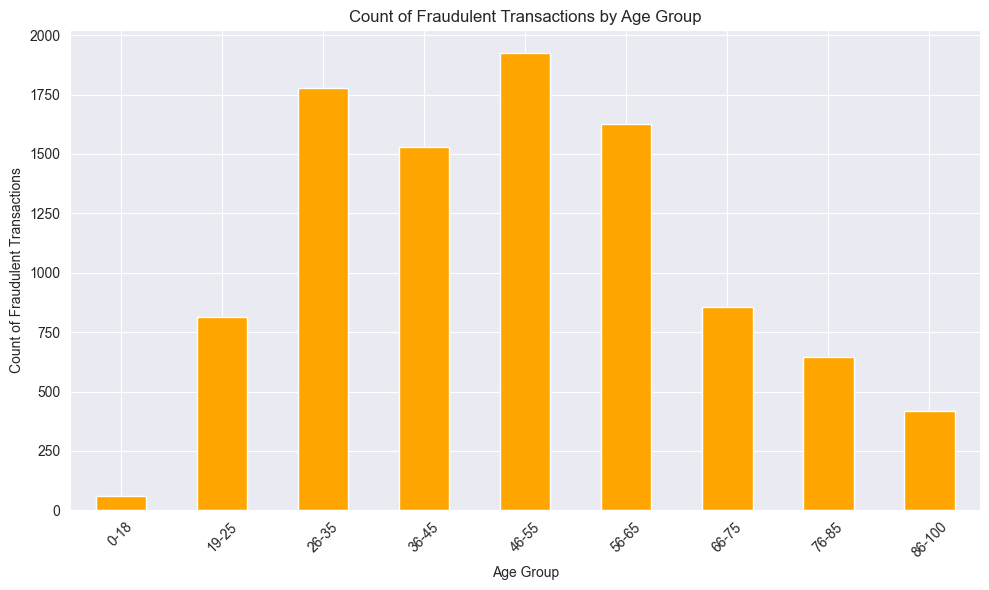

In [69]:
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-100']
data['age_group'] = pd.cut(data['age_at_transaction'], bins=bins, labels=labels, right=False)

# Filter for fraudulent transactions
fraud_transactions = data[data['is_fraud'] == 1]

# Group by 'age_group' and count transactions
fraud_counts_by_age_group = fraud_transactions['age_group'].value_counts().sort_index()

# Visualizing the counts
fig, ax = plt.subplots(figsize=(10, 6))
fraud_counts_by_age_group.plot(kind='bar', color='orange', ax=ax)
ax.set_title('Count of Fraudulent Transactions by Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Count of Fraudulent Transactions')
ax.set_xticklabels(fraud_counts_by_age_group.index, rotation=45)
plt.tight_layout()
plt.show()



In [70]:
fraud_counts_by_age_group

age_group
0-18        60
19-25      813
26-35     1778
36-45     1531
46-55     1924
56-65     1626
66-75      855
76-85      644
86-100     420
Name: count, dtype: int64

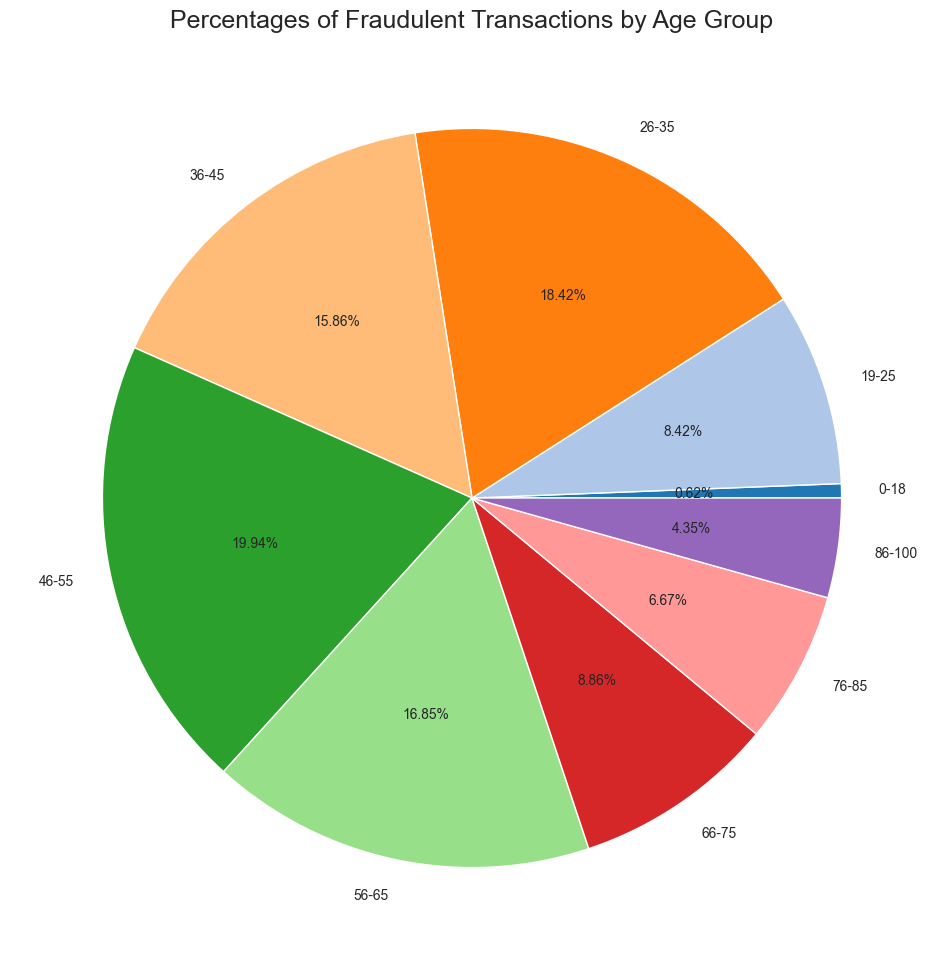

In [71]:
# Calculate percentages
total_fraud_count = fraud_counts_by_age_group.sum()
fraud_percentages_by_age_group = (fraud_counts_by_age_group / total_fraud_count) * 100

fig, ax = plt.subplots(figsize=(12, 12))
fraud_percentages_by_age_group.plot(kind='pie', ax=ax, autopct='%1.2f%%', startangle=0, colors=plt.cm.tab20.colors)
ax.set_ylabel('')  
ax.set_title('Percentages of Fraudulent Transactions by Age Group', fontsize=18)
plt.show()

Based on the fraud percentages by age group shown in the figure above, it is evident that certain age groups are more susceptible to fraudulent transactions than others. The data shows that the age group 46-55 has the highest percentage of fraudulent transactions at 19.94%, closely followed by the 26-35 age group at 18.42%, and then the 56-65 age group at 16.85%. This suggests that middle-aged individuals, particularly those between the ages of 46 and 55, are the most targeted or susceptible group for fraudulent activities within this dataset. On the other hand, the youngest (0-18) and the oldest (86-100) age groups show the lowest percentages of fraudulent transactions, at 0.62% and 4.35%, respectively.

'age_group' or 'age' should be used as a feature in our model.

# Q3: If a fraudulent transaction has been committed, what is the expected number of transaction committed per day with the same victim? 
Temporal component asking do fraudulent transactions occur multiple times on the same customer

In [72]:
# Group 'fraud_transactions' by 'cc_num' and 'trans_date', then count transactions
fraud_per_day_per_victim = fraud_transactions.groupby(['cc_num', 'trans_date']).size()
fraud_per_day_per_victim.head(20)

transaction_count_frequencies = fraud_per_day_per_victim.value_counts().sort_index()

# Initialize a range of transaction counts
max_transaction_count = fraud_per_day_per_victim.max()
all_possible_counts = pd.Series(0, index=range(1, max_transaction_count + 1))

# Update this series with the actual frequencies
all_possible_counts.update(transaction_count_frequencies)
all_possible_counts

1      85
2     163
3     269
4     345
5     347
6     262
7     175
8     133
9      83
10     35
11     16
12      8
13      2
14      0
15      2
16      2
dtype: int64

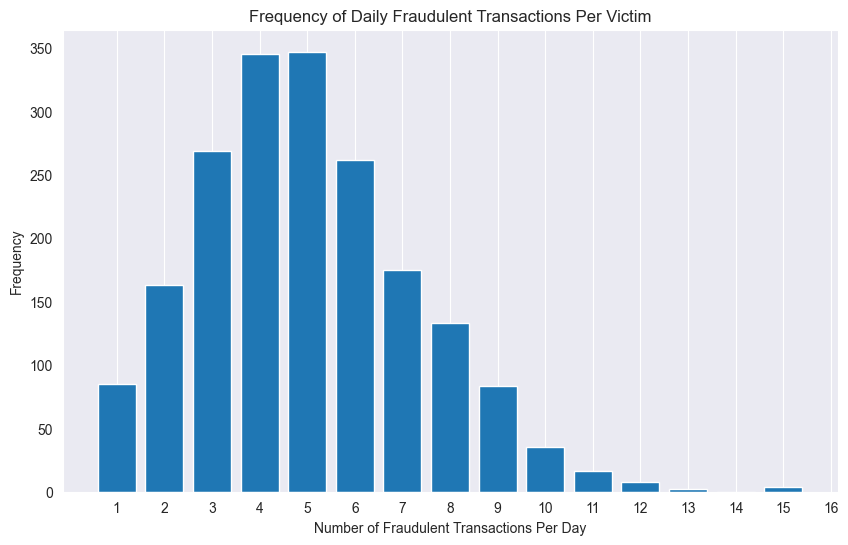

In [73]:
# Plotting a histogram of the counts
plt.figure(figsize=(10, 6))
fraud_per_day_per_victim.hist(bins=range(1, fraud_per_day_per_victim.max() + 1), align='left', rwidth=0.8)
plt.title('Frequency of Daily Fraudulent Transactions Per Victim')
plt.xlabel('Number of Fraudulent Transactions Per Day')
plt.ylabel('Frequency')
plt.xticks(range(1, fraud_per_day_per_victim.max() + 1))  #
plt.grid(axis='y')

plt.show()


The histogram above shows the distribution of the number of fraudulent transactions with the same victim per day, offering insights into the behavior or temporal pattern of fraudulent activities targeting individual customers. Moderately low transaction counts, specifically between 3 to 6 transactions per day, emerge as the most prevalent, with a notable peak observed at 4 to 5 transactions per day, each nearing 350 occurrences. In contrast, higher transaction counts, particularly 10 transactions and above, are significantly less common, with their frequency quickly tapering off to below 20 occurrence. 

We should figure out a way to transform 'trans_date' such that we can include it as a feature to our model. 

# Q4: For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions

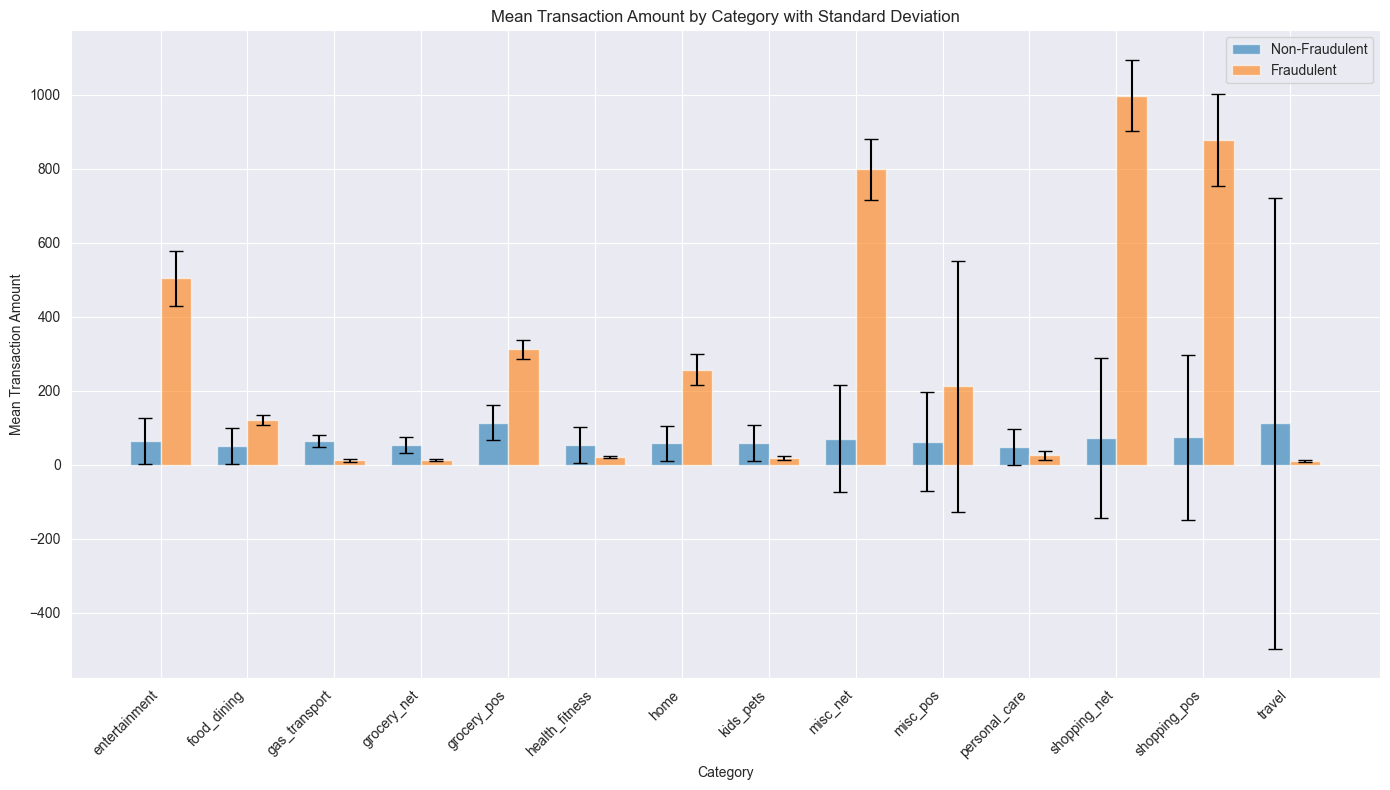

In [74]:
# Group data by category and is_fraud, then calculate mean and std
category_stats = data.groupby(['category', 'is_fraud'])['amt'].agg(['mean', 'std']).reset_index()

# Separating into fraudulent and non-fraudulent 
fraudulent = category_stats[category_stats['is_fraud'] == 1]
non_fraudulent = category_stats[category_stats['is_fraud'] == 0]

# Plotting
x_coords = np.arange(len(category_stats['category'].unique()))

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35 

# Plotting both fraudulent and non-fraudulent bars
ax.bar(x_coords - bar_width/2, non_fraudulent['mean'], yerr=non_fraudulent['std'], width=bar_width, label='Non-Fraudulent', align='center', alpha=0.6, capsize=5)
ax.bar(x_coords + bar_width/2, fraudulent['mean'], yerr=fraudulent['std'], width=bar_width, label='Fraudulent', align='center', alpha=0.6, capsize=5)

ax.set_xlabel('Category')
ax.set_ylabel('Mean Transaction Amount')
ax.set_title('Mean Transaction Amount by Category with Standard Deviation')
ax.set_xticks(x_coords)
ax.set_xticklabels(category_stats['category'].unique(), rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


It appears that fraud risks in 'shopping_net','shopping_pos','misc_net', and 'entertainment' tend to be higher compared to legitimate transactions. Meaning transactions under these categories are more susceptible to higher-value fraud. We should include the features 'amt' and 'categories' into our fraud detection model.

# Q5. What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?

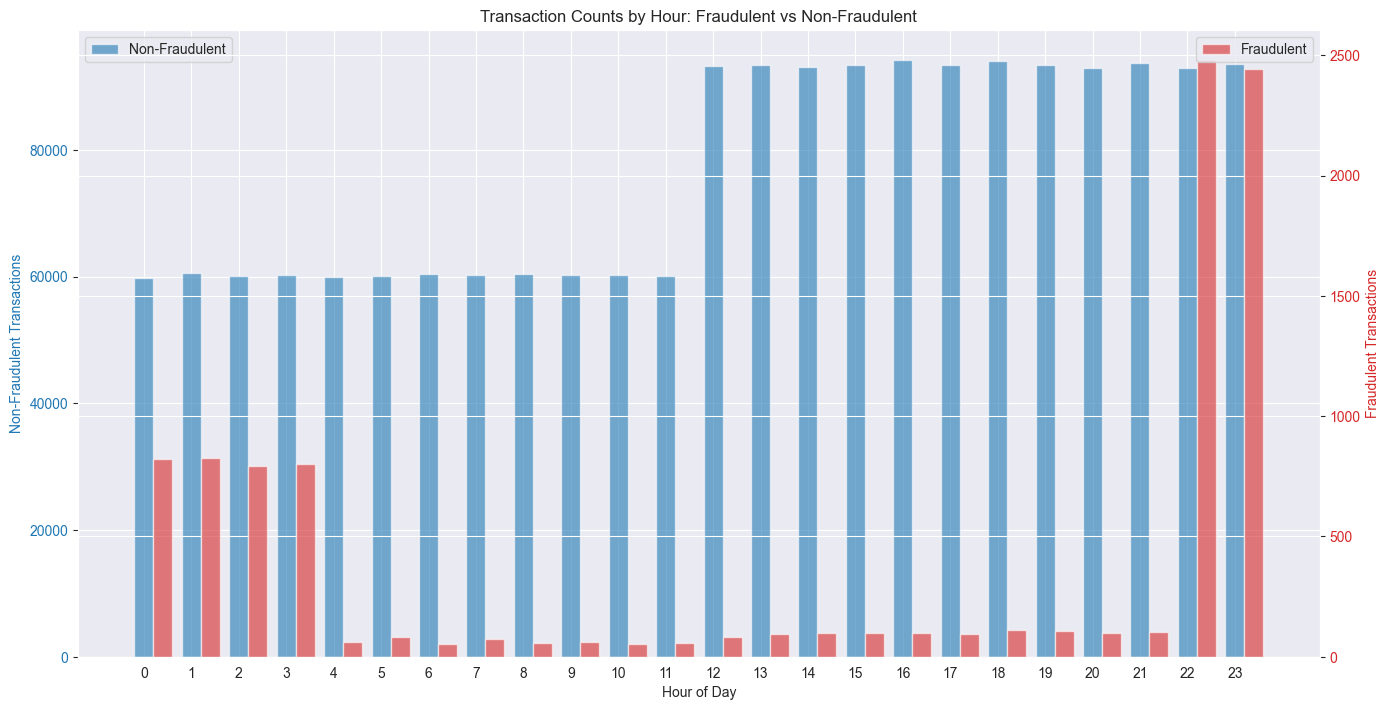

In [75]:
# Extract the hour from the transaction time
data['trans_hour'] = data['trans_date_trans_time'].dt.hour

# Calculate the distribution of transactions by hour
fraudulent_transactions_hourly = data[data['is_fraud'] == 1].groupby('trans_hour').size()
non_fraudulent_transactions_hourly = data[data['is_fraud'] == 0].groupby('trans_hour').size()
transactions_by_hour = data.groupby(['trans_hour', 'is_fraud']).size().unstack(fill_value=0)


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for non-fraudulent transactions
color = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Non-Fraudulent Transactions', color=color)
non_fraudulent_bars = ax1.bar(transactions_by_hour.index, transactions_by_hour[0], color=color, label='Non-Fraudulent', alpha=0.6, width=0.4, align='center')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(transactions_by_hour.index)
ax1.set_xticklabels(transactions_by_hour.index)

# Instantiate a second y-axis for fraudulent transactions
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fraudulent Transactions', color=color)
fraudulent_bars = ax2.bar(transactions_by_hour.index + 0.4, transactions_by_hour[1], color=color, label='Fraudulent', alpha=0.6, width=0.4, align='center')
ax2.tick_params(axis='y', labelcolor=color)

# Adding some custom adjustments
fig.tight_layout()
plt.title('Transaction Counts by Hour: Fraudulent vs Non-Fraudulent')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [76]:
# Find the top6 hour with the maximum number of fraudulent transactions
top6_fraudulent_hour = transactions_by_hour[1].sort_values(ascending=False).head(6)
print(top6_fraudulent_hour)

trans_hour
22    2481
23    2442
1      827
0      823
3      803
2      793
Name: 1, dtype: int64


The hours with the highest number of fraudulent transactions are late at night, specifically around 22:00 (10 PM) and 23:00 (11 PM), with 2481 and 2442 fraudulent transactions, respectively. After the peak hours, there's a significant drop but still notable counts in the early morning hours: 01:00 (1 AM) with 827 transactions, 00:00 (midnight) with 823 transactions, 03:00 (3 AM) with 803 transactions, and 02:00 (2 AM) with 793 transactions. This indicates a trend where fraudulent activity remains high during the late night to early morning hours.

We should definitely include 'trans_hours' as a feature to our model. We can leave it as is or transform it to groups like : early morning, late morning, afternoon, night, late night.

# Q6. Is there a relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transactions?

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#:~:text=The%20Haversine%20(or%20great%20circle,the%20data%20must%20be%202.

In [77]:
# Convert lat and long features to radians
data['lat_rad'] = np.radians(data['lat'])
data['long_rad'] = np.radians(data['long'])
data['merch_lat_rad'] = np.radians(data['merch_lat'])
data['merch_long_rad'] = np.radians(data['merch_long'])

# Calculate distances using haversine_distances for each pair
# May take a while to calculate (4min)
distances_km = []
for i, row in data.iterrows():
    customer_location = [[row['lat_rad'], row['long_rad']]]
    merchant_location = [[row['merch_lat_rad'], row['merch_long_rad']]]
    distance_rad = haversine_distances(customer_location, merchant_location)
    distance_km = distance_rad * 6371  # Convert from radians to kilometers
    distances_km.append(distance_km[0][0])

# Add the calculated distances back to the DataFrame
data['distance_km'] = distances_km



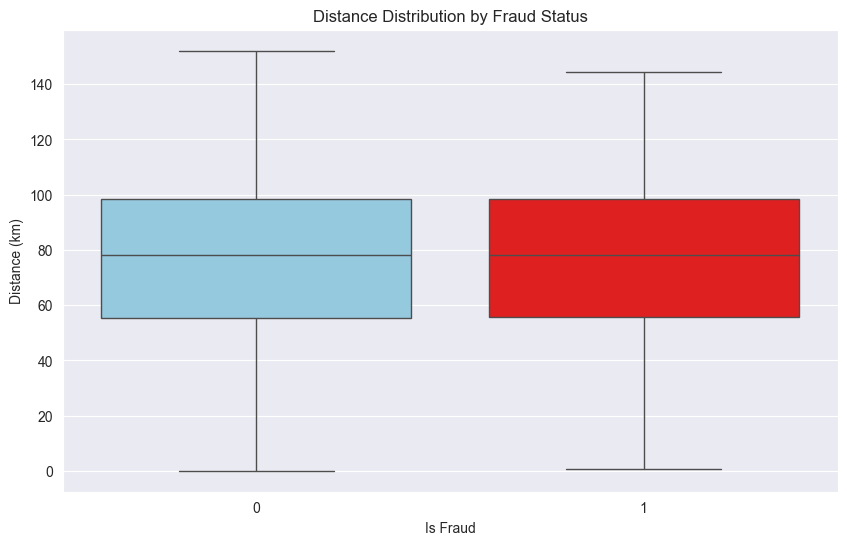

In [78]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='distance_km', data=data, palette=['skyblue', 'red'])
plt.title('Distance Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Distance (km)')
plt.show()


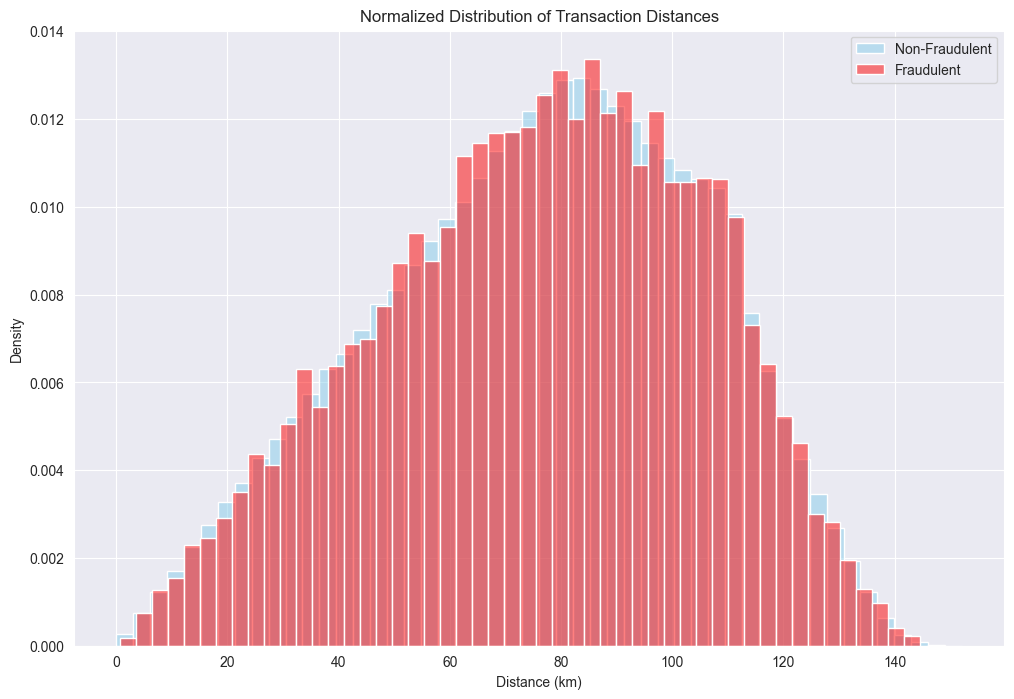

In [79]:
plt.figure(figsize=(12, 8))
sns.histplot(data[data['is_fraud'] == 0]['distance_km'], color="skyblue", label='Non-Fraudulent', kde=False, bins=50, alpha=0.5, stat="density")
sns.histplot(data[data['is_fraud'] == 1]['distance_km'], color="red", label='Fraudulent', kde=False, bins=50, alpha=0.5, stat="density")

plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.title('Normalized Distribution of Transaction Distances')
plt.legend()
plt.show()



By looking at the side-by-side boxplot and the normalized overlaid histograms, we can see that there is no association between 'Distance_km' and fraudulent transactions. Therefore, we do not have to use 'Distance_km' as a feature in our model.

# Q7. Are certain states, cities, and zip codes more susceptible to fraudulent transactions?

### STATES

In [104]:
# Calculate the count of fraudulent transactions by state
fraud_counts_by_state = data[data['is_fraud'] == 1].groupby('state').size()

# Calculate the total transactions and fraud rate by state
total_transactions_by_state = data.groupby('state').size()
fraud_rates_by_state = (fraud_counts_by_state / total_transactions_by_state) * 100


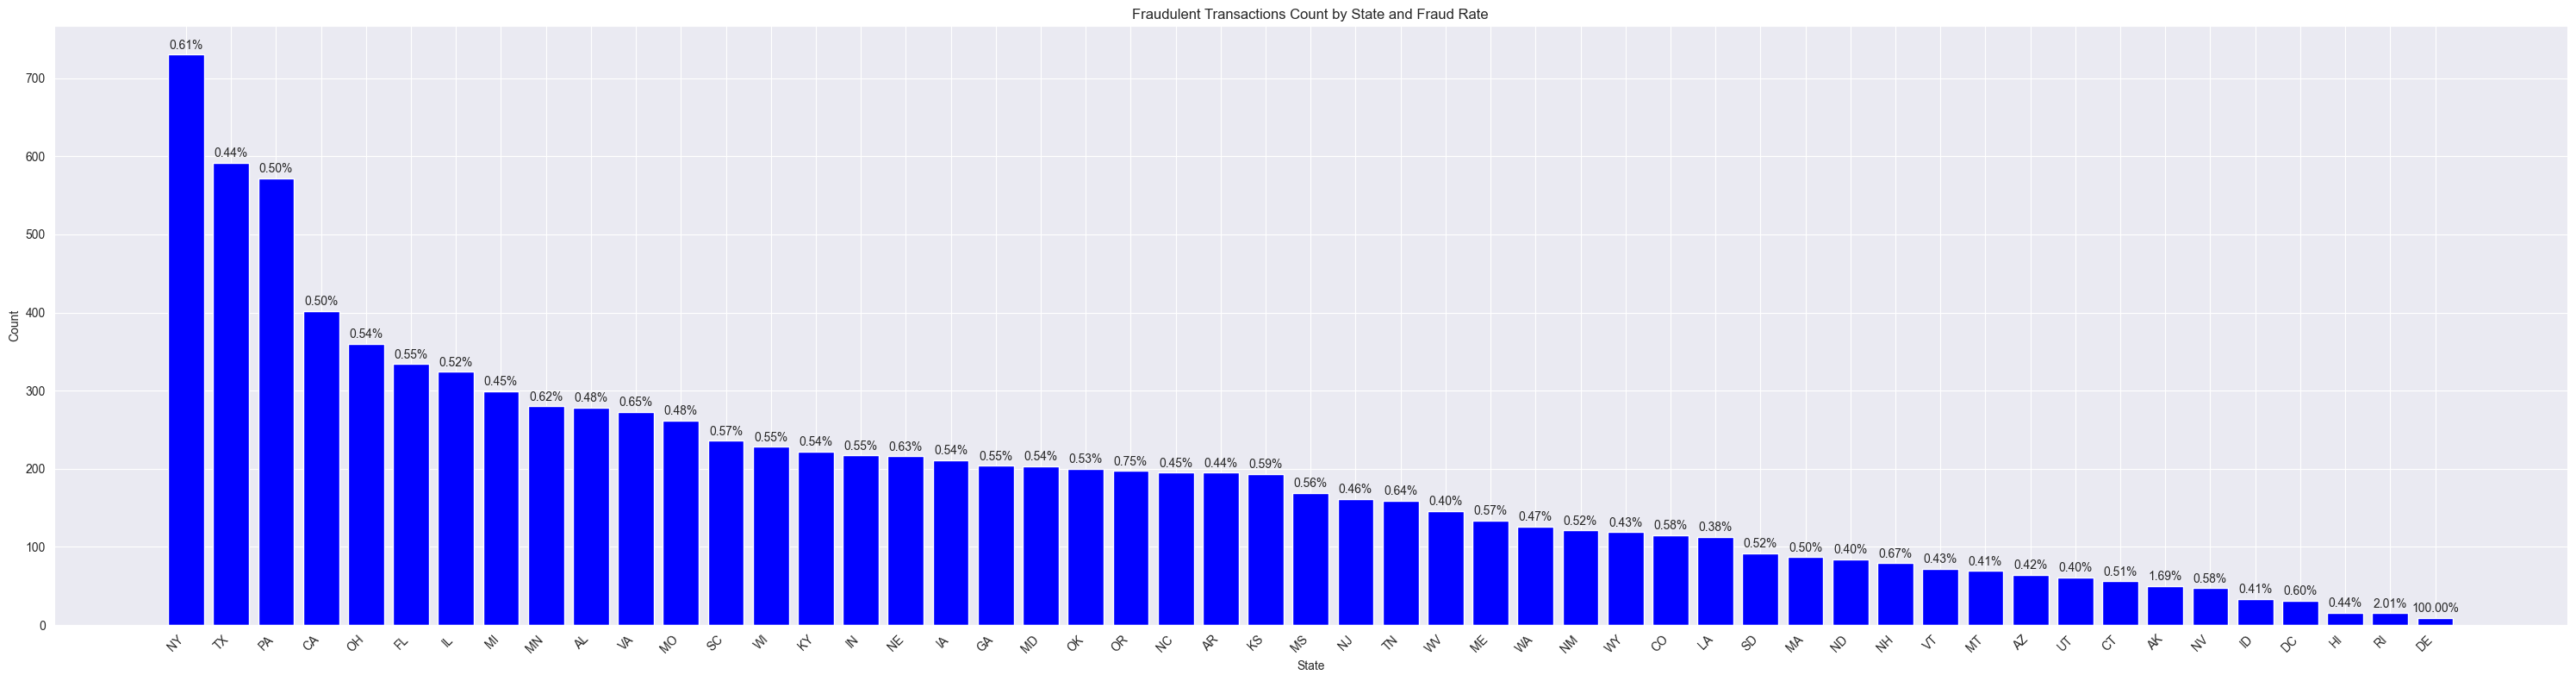

In [106]:
fraud_counts_by_state.sort_values(ascending=False, inplace=True)
top_states = fraud_counts_by_state


# Plotting
plt.figure(figsize=(30, 8))
x = np.arange(len(top_states))
plt.bar(x, fraud_counts_by_state[top_states.index], color='blue')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Fraudulent Transactions Count by State and Fraud Rate')
plt.xticks(x, top_states.index, rotation=45, ha='right')  # Set x-axis labels


# Adding percentage text on top of each bar
for i, state in enumerate(top_states.index):
    plt.text(i,  fraud_counts_by_state[state] + 0.01 *  fraud_counts_by_state.max(), f'{fraud_rates_by_state[state]:.2f}%', ha='center')

plt.tight_layout()
plt.show()



In [82]:
print(fraud_counts_by_state)


state
NY    730
TX    592
PA    572
CA    402
OH    360
FL    334
IL    324
MI    299
MN    280
AL    278
VA    273
MO    262
SC    236
WI    228
KY    222
IN    217
NE    216
IA    211
GA    204
MD    203
OK    200
OR    197
NC    195
AR    195
KS    193
MS    169
NJ    161
TN    159
WV    146
ME    134
WA    126
NM    121
WY    119
CO    115
LA    113
SD     92
MA     87
ND     84
NH     79
VT     72
MT     69
AZ     64
UT     61
CT     56
AK     50
NV     47
ID     33
DC     31
HI     16
RI     15
DE      9
dtype: int64


Based on the fraud counts and fraud rates by state, New York (NY) stands out at the top, with 730 reported cases of fraud, followed closely by Texas (TX) and Pennsylvania (PA), showcasing a notable concentration of fraudulent activity in populous states. Conversely, the fraud rate, especially in states with fewer transactions, reveals the proportionate impact of fraud, offering insights into how fraud prevalence relative to transaction volume varies across states. Delaware (DE) experienced 9 fraud transactions with no recorded non-fraudulent transactions, highlighting an anomaly within the dataset.


### CITIES

In [83]:
# Group by city and list unique states
cities_states = data.groupby('city').agg({'state': lambda x: set(x)})

# Filter cities present in more than one state 
cities_with_multiple_states = cities_states[cities_states['state'].apply(len) > 1]
cities_with_multiple_states

,state
city,
Afton,"{MN, MI}"
Allentown,"{PA, GA, NY}"
Andrews,"{NC, IN}"
Arcadia,"{SC, MI, OH}"
Bay City,"{MI, OR}"
Benton,"{WI, TN}"
Birmingham,"{IA, AL}"
Brandon,"{FL, VT}"
Burbank,"{WA, OK}"


The table above shows that 'city' is not unique, meaning two customers can have the same 'city' entry but different 'state' entry.

In [84]:
# Group fraud counts by city and state
fraud_counts_by_city_state = data[data['is_fraud'] == 1].groupby(['city', 'state']).size()

# Calculate total transactions by city and state
total_transactions_by_city_state = data.groupby(['city', 'state']).size()
fraud_cases_by_pop = fraud_transactions.groupby(['city', 'state', 'city_pop']).size()

# Calculate fraud rates by city-state
fraud_rates_by_city_state = (fraud_counts_by_city_state / total_transactions_by_city_state) * 100

# Creating a DataFrame from the series
fraud_summary = pd.DataFrame({
    'fraud_counts': fraud_counts_by_city_state,
    'fraud_rate': fraud_rates_by_city_state,
}).reset_index()

# Sort by fraud counts and select the top 20
top_fraud_cities = fraud_summary.sort_values(by='fraud_counts', ascending=False).head(20)


,city,state,fraud_counts,fraud_rate
381,Houston,TX,39.0,0.66
210,Dallas,TX,39.0,0.76
595,New York City,NY,35.0,0.95
229,Detroit,MI,33.0,0.64
884,Washington,DC,31.0,0.60
391,Huntsville,AL,29.0,0.57
585,Naples,FL,29.0,0.50
852,Tulsa,OK,27.0,0.61
848,Topeka,KS,27.0,0.61
761,San Antonio,TX,25.0,0.34


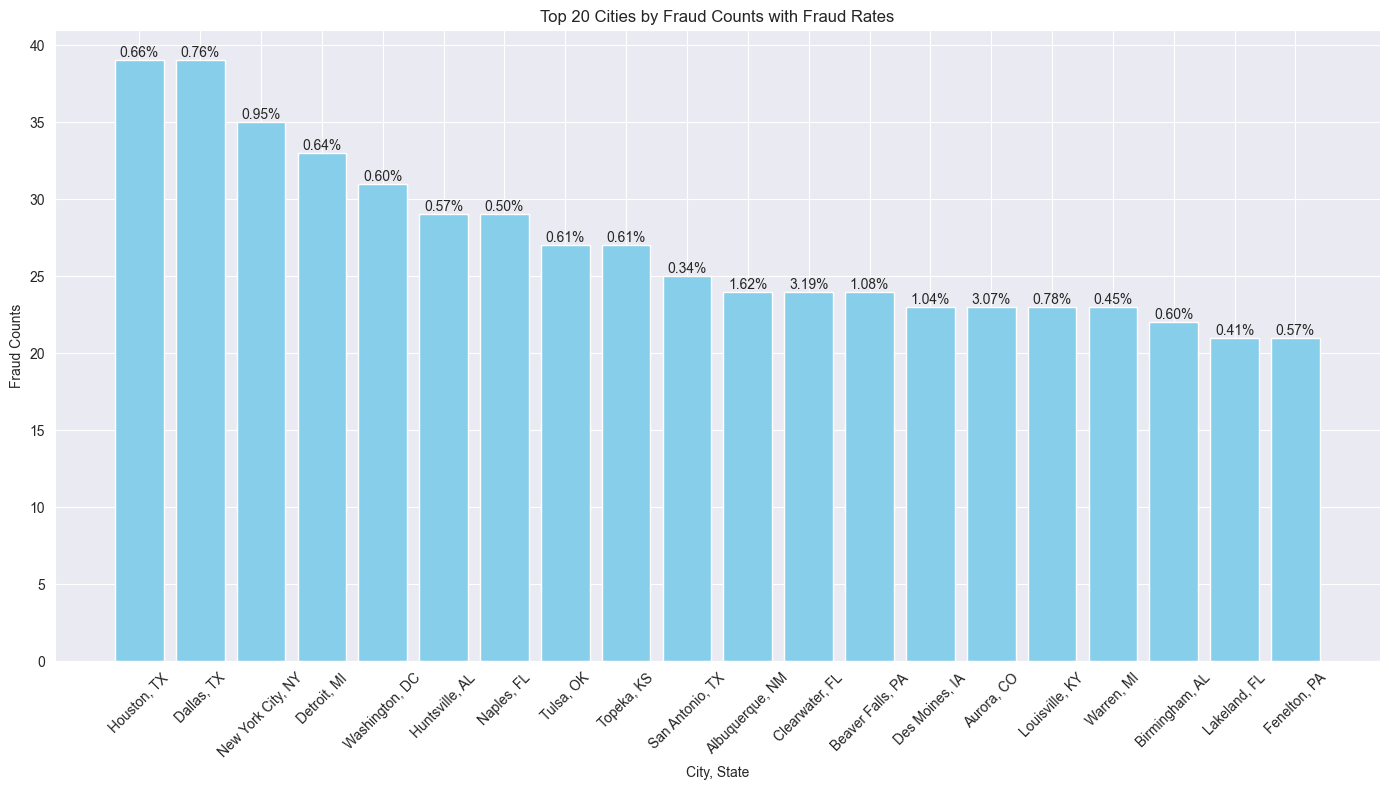

In [85]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot for fraud counts
bars = ax.bar(top_fraud_cities['city'] + ', ' + top_fraud_cities['state'], top_fraud_cities['fraud_counts'], color='skyblue')

# Annotate bars with fraud rate
for bar, fraud_rate in zip(bars, top_fraud_cities['fraud_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{fraud_rate:.2f}%', 
            ha='center', va='bottom')

ax.set_xlabel('City, State')
ax.set_ylabel('Fraud Counts')
ax.set_title('Top 20 Cities by Fraud Counts with Fraud Rates')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

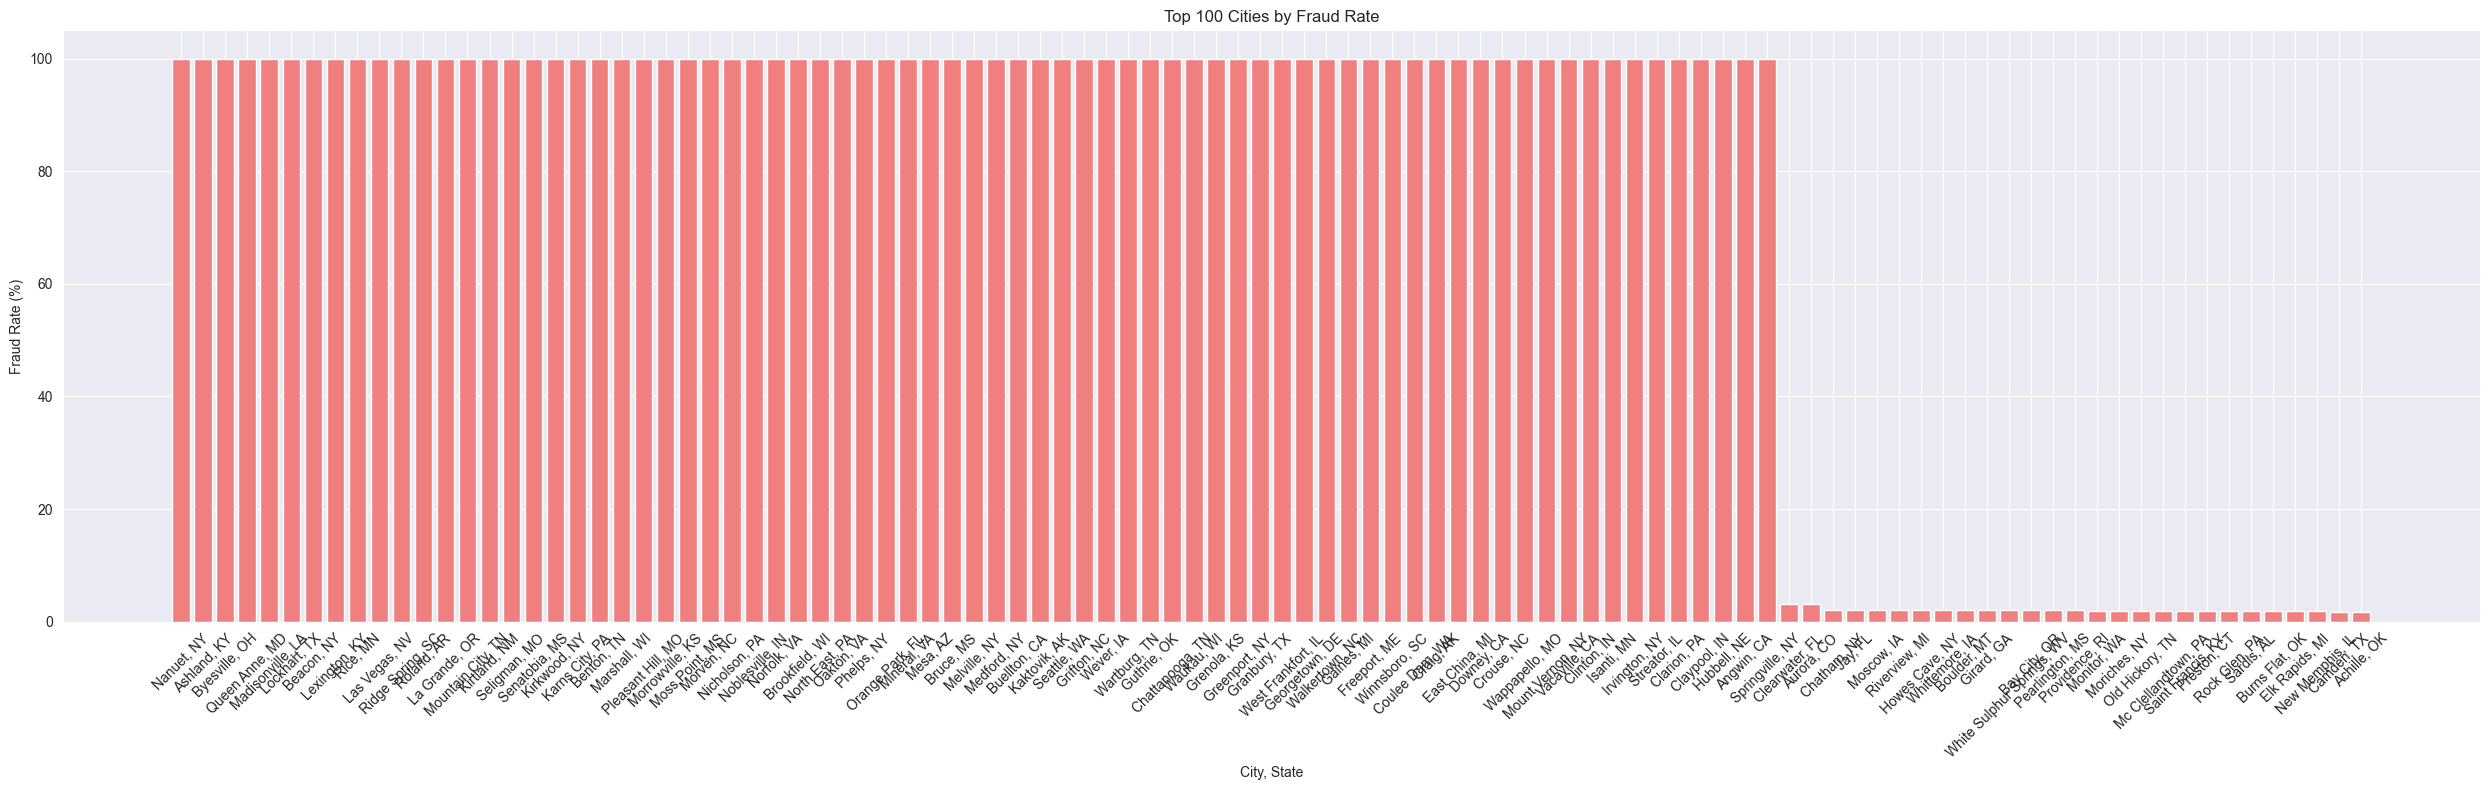

In [86]:
# Sort by fraud rate this time, and select the top 100 cities for fraud rate
top_fraud_rate_cities = fraud_summary.sort_values(by='fraud_rate', ascending=False).head(100)

# Plotting
fig, ax = plt.subplots(figsize=(25, 8))

# Bar plot for fraud rates
bars = ax.bar(top_fraud_rate_cities['city'] + ', ' + top_fraud_rate_cities['state'], top_fraud_rate_cities['fraud_rate'], color='lightcoral')

# Adding labels to each bar
ax.set_xlabel('City, State')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Top 100 Cities by Fraud Rate')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The figures above indicates that certain cities are indeed more susceptible to fraudulent activities. In terms of fraud counts, Houston, TX, and Dallas, TX, leading the list with 39 fraud cases each, followed by significant numbers in New York City, NY, and Detroit, MI. In terms of fraud rates, multiple cities have 100% fraud rates. Indicating that all transactions in these cities are fraudulent.

We should include 'city' to our model by first transform it to 'city_state' since the 'city' is not unique. Meaning, city names can be found in multiple states. 

### ZIPCODE

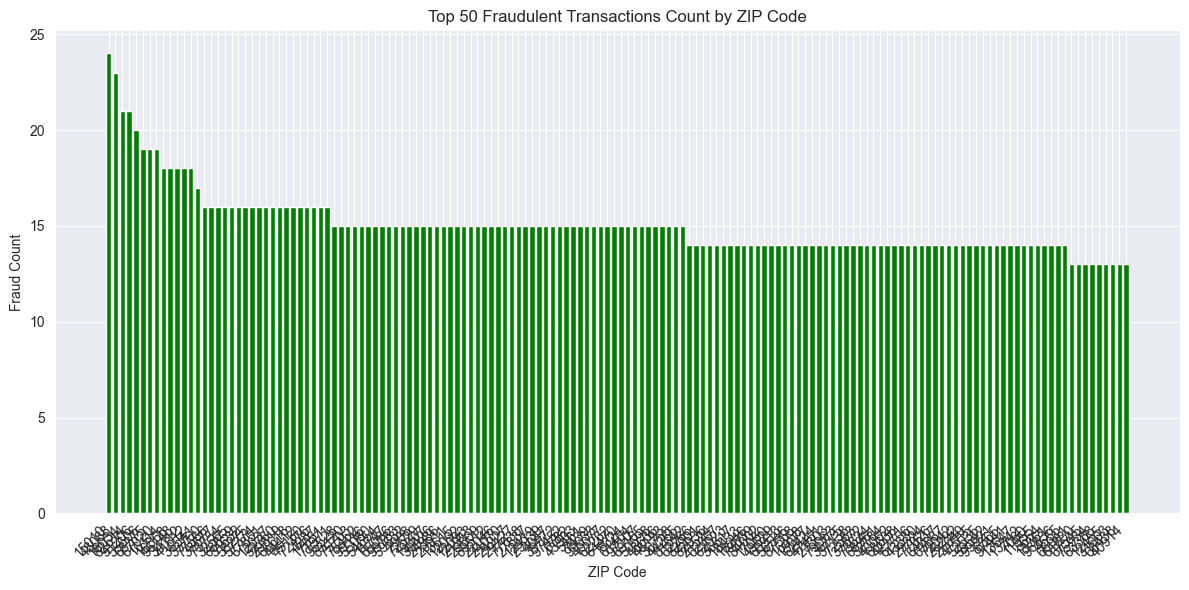

In [87]:
#Group fraud counts by zip
fraud_counts_by_zip= data[data['is_fraud'] == 1].groupby('zip').size()
fraud_counts_by_zip.sort_values(ascending=False, inplace=True)

# Select the top ZIP codes by fraud count
top_zips = fraud_counts_by_zip.head(150)

# Plotting
plt.figure(figsize=(12, 6))

# Create an array for x-axis positions
x = np.arange(len(top_zips))

# Plotting bars for fraudulent transactions in the top ZIP codes
plt.bar(x, fraud_counts_by_zip[top_zips.index], color='green')

# Adding labels and title
plt.xlabel('ZIP Code')
plt.ylabel('Fraud Count')
plt.title('Top 50 Fraudulent Transactions Count by ZIP Code')

plt.xticks(x, top_zips.index, rotation=45, ha='right')


plt.tight_layout() 
plt.show()

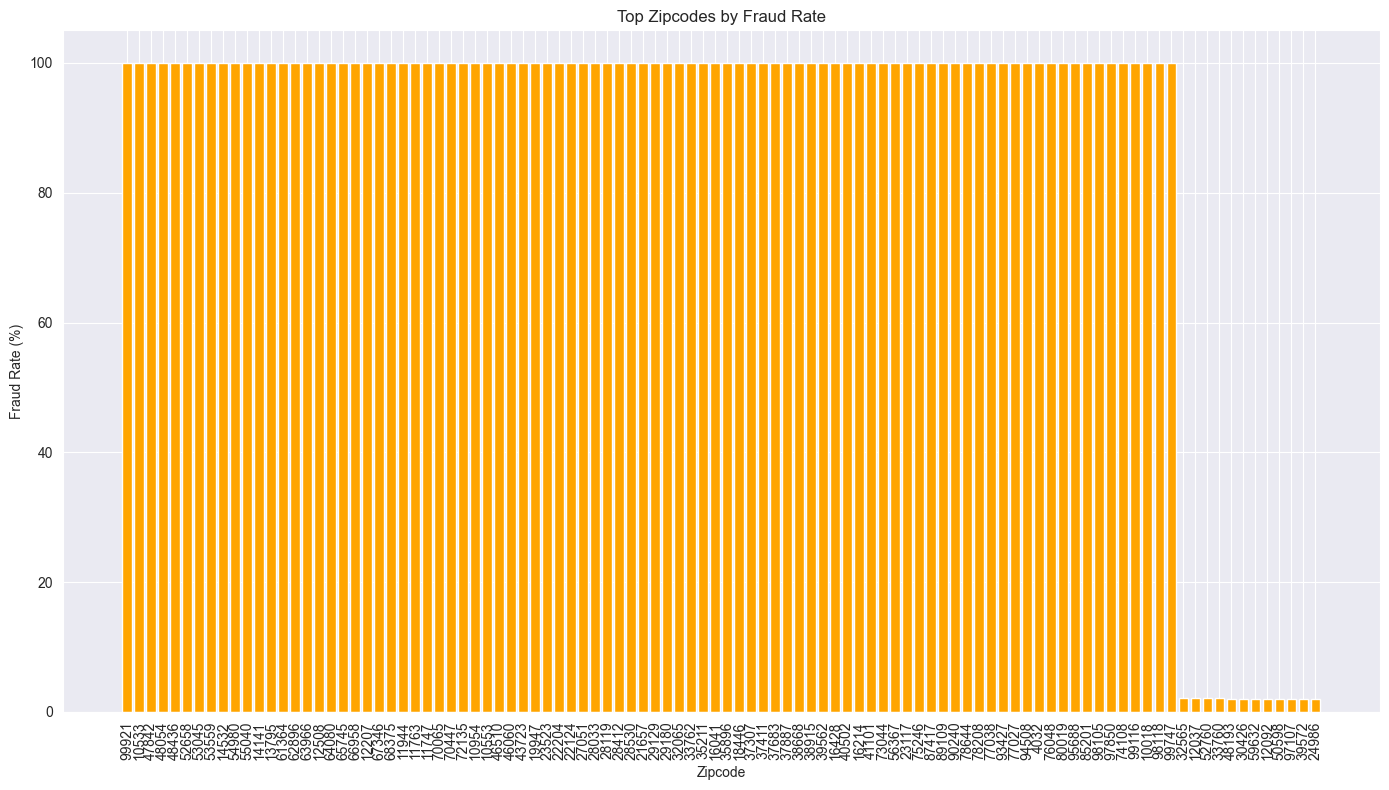

In [88]:
# Calculate total transactions by zip
total_transactions_by_zip = data.groupby('zip').size()

# Calculate fraud rates by zip (fraud counts divided by total transactions)
fraud_rates_by_zip = (fraud_counts_by_zip / total_transactions_by_zip) * 100

fraud_rates_by_zip_df = pd.DataFrame({
    'fraud_counts': fraud_counts_by_zip,
    'fraud_rate': fraud_rates_by_zip,
}).reset_index()

# Visualize top fraud rates
fraud_rates_by_zip_df.sort_values(by='fraud_rate', ascending=False, inplace=True)

top_fraud_rate_zipcodes = fraud_rates_by_zip_df.head(100)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot for fraud rates by zipcode
bars = ax.bar(top_fraud_rate_zipcodes['zip'].astype(str), top_fraud_rate_zipcodes['fraud_rate'], color='orange')

# Adding labels to each
ax.set_xlabel('Zipcode')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Top Zipcodes by Fraud Rate')
ax.tick_params(axis='x', rotation=90) # Rotate for better readability

plt.tight_layout()
plt.show()


The figures above show that certain zipcodes are susceptible to fraud. However, we might not include 'zip' as a feature to our model since it will be difficult to encode and might be collinear with 'city_state'.  

# Q8. What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?

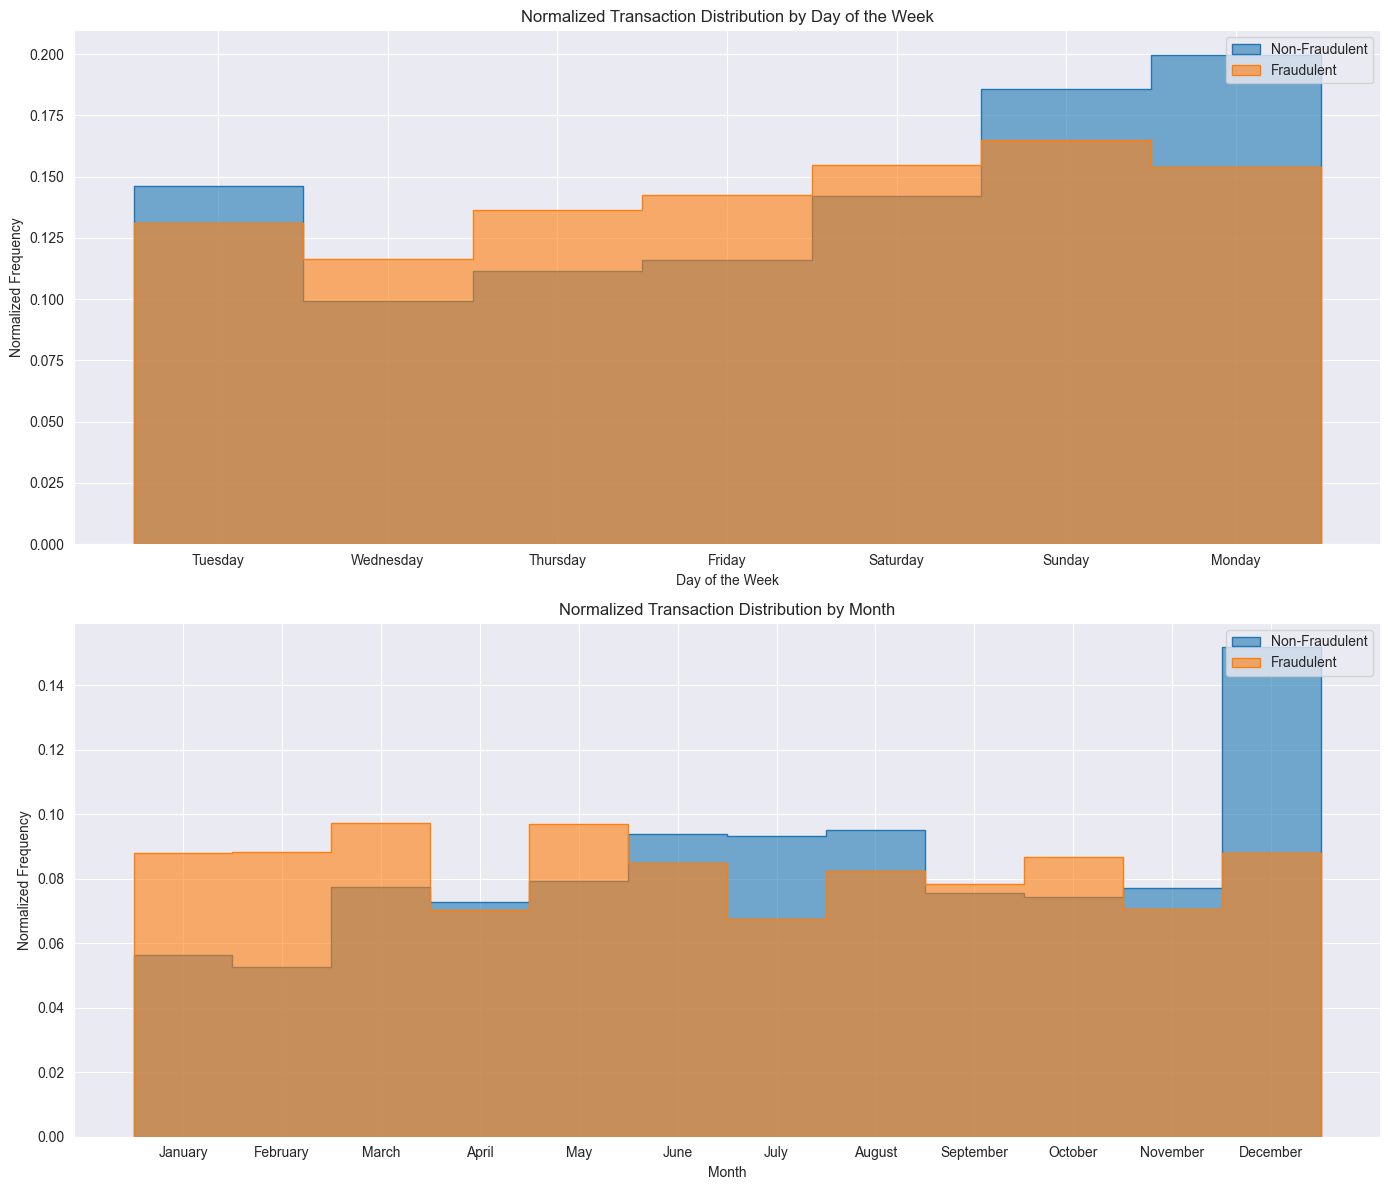

In [89]:
data['day_of_week'] = data['trans_date'].dt.day_name()
data['month'] = data['trans_date'].dt.month_name()

# Plots
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Normalized overlaid histogram for Day of the Week
for is_fraud, group_data in data.groupby('is_fraud'):
    sns.histplot(group_data['day_of_week'], stat='density', kde=False, 
                 binwidth=0.5, ax=ax[0], label=f'{"Fraudulent" if is_fraud else "Non-Fraudulent"}', 
                 alpha=0.6, element='step')

ax[0].set_title('Normalized Transaction Distribution by Day of the Week')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Normalized Frequency')
ax[0].legend()

# Normalized overlaid histogram for Month
for is_fraud, group_data in data.groupby('is_fraud'):
    sns.histplot(group_data['month'], stat='density', kde=False, 
                 binwidth=0.5, ax=ax[1], label=f'{"Fraudulent" if is_fraud else "Non-Fraudulent"}', 
                 alpha=0.6, element='step')

ax[1].set_title('Normalized Transaction Distribution by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Normalized Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()


The normalized overlaid histograms shown above signifies no association between day of the weak/ month of the year and fraudulent transactions. Therefore, we do not have to include these as features to our model.

# Q9. Compared to any other time of the year, how prevalent are fraudulent transactions during the holidays (11-30 to 12-31)? During post-holidays (1-1 to 2-28)? During the summer (05-24 to 09-01)?

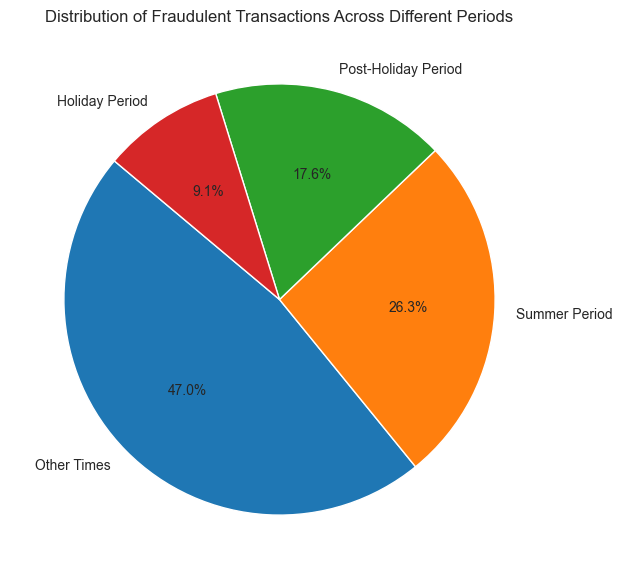

In [92]:
fraudulent_transactions = data[data['is_fraud'] == 1]

# Total number of fraudulent transactions
total_fraudulent_transactions = len(fraudulent_transactions)

# Function that checks if a date falls within a given period (ignoring the year)
def in_period(date, start_month, start_day, end_month, end_day):
    if start_month <= end_month:
        return (date.month > start_month or (date.month == start_month and date.day >= start_day)) and \
               (date.month < end_month or (date.month == end_month and date.day <= end_day))
    else: # For periods that wrap around the year
        return not ((date.month < start_month or (date.month == start_month and date.day < start_day)) and \
                    (date.month > end_month or (date.month == end_month and date.day > end_day)))


# Calculate periods
fraudulent_transactions['period'] = 'Other Times'  # Default category
fraudulent_transactions.loc[fraudulent_transactions['trans_date'].apply(lambda x: in_period(x, 11, 30, 12, 31)), 'period'] = 'Holiday Period'
fraudulent_transactions.loc[fraudulent_transactions['trans_date'].apply(lambda x: in_period(x, 1, 1, 2, 28)), 'period'] = 'Post-Holiday Period'
fraudulent_transactions.loc[fraudulent_transactions['trans_date'].apply(lambda x: in_period(x, 5, 24, 9, 1)), 'period'] = 'Summer Period'

# Count transactions in each category
period_counts = fraudulent_transactions['period'].value_counts()

# Visualization
plt.figure(figsize=(10, 7))
plt.pie(period_counts, labels=period_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraudulent Transactions Across Different Periods')
plt.show()



There is significant difference among each period. However, we have to keep in mind that the number of days in each period are not constant. For example, 26.3 percent of the fraud transactions occurred during summer which seems significant. However, the summer period is 100/365 or 27% of the year.

Compare it to post-holiday period which is 17.6% of the fraud transactions and is 58/365 or 15% of the year. 

Lastly, the holiday period wih 9.1% of the fraud transactions and is 31/365 or 8% of the year.


Therefore, stratifying the dates into 'periods' will not give us additional information and should not be included in our model.

# Q10. Is there a relationship between 'city_pop' and incidence of fraud?

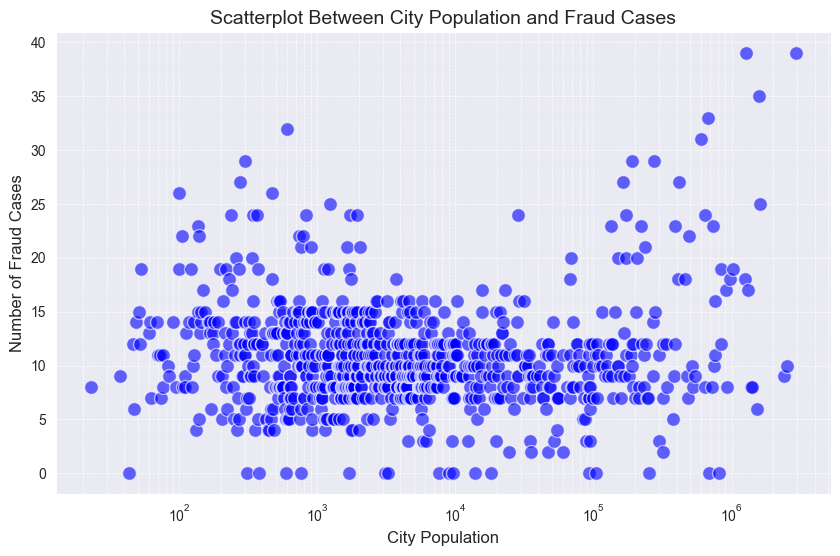

In [93]:
# Group by 'city_pop' and calculate the fraud counts
fraud_cases_by_pop = data.groupby('city_pop')['is_fraud'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(fraud_cases_by_pop['city_pop'], fraud_cases_by_pop['is_fraud'], color='blue', alpha=0.6, edgecolors='w', s=100)

# Adding plot labels and title
plt.title('Scatterplot Between City Population and Fraud Cases', fontsize=14)
plt.xlabel('City Population', fontsize=12)
plt.ylabel('Number of Fraud Cases', fontsize=12)
plt.xscale('log')  # Using a logarithmic scale for better visualization
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

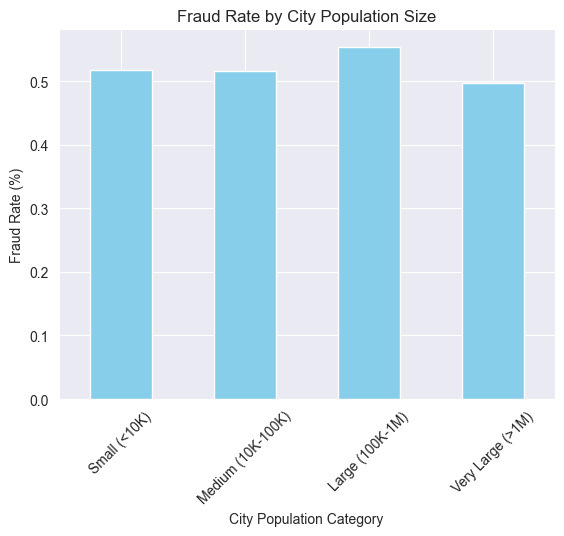

In [94]:
# Stratify 'city_pop'
bins = [0, 10000, 100000, 1000000, np.inf]
labels = ['Small (<10K)', 'Medium (10K-100K)', 'Large (100K-1M)', 'Very Large (>1M)']

data['city_pop_category'] = pd.cut(data['city_pop'], bins=bins, labels=labels)

# Calculate fraud rates by population category
fraud_rates_by_pop_category = data.groupby('city_pop_category')['is_fraud'].mean() * 100

# Plot
fraud_rates_by_pop_category.plot(kind='bar', color='skyblue')
plt.xlabel('City Population Category')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by City Population Size')
plt.xticks(rotation=45)
plt.show()

The scatter plot and bar chart show that city population size does not directly dictate the prevalence of fraud. Therefore, we do not have to use it as a feature in our model. 

# Q11. Are certain "job" types susceptible to fraudulent transactions?


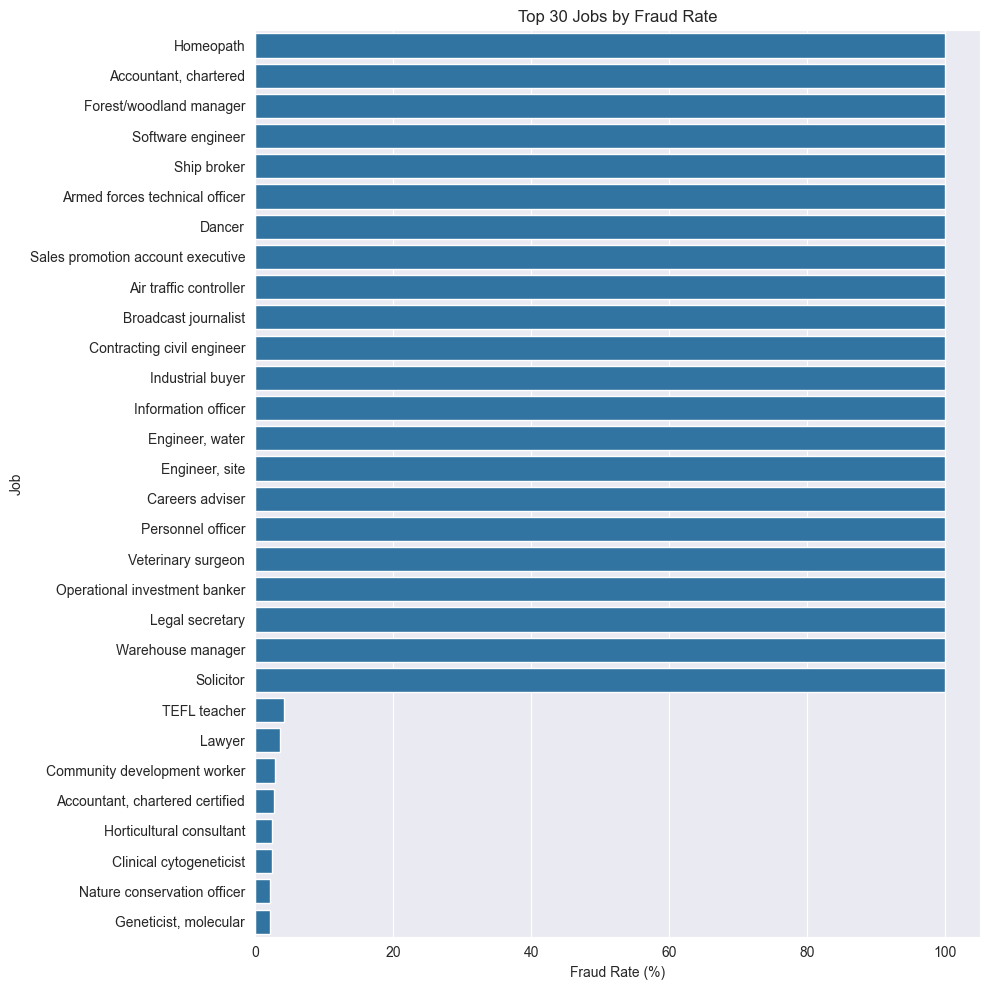

In [95]:
job_fraud_rate = data.groupby('job')['is_fraud'].mean().sort_values(ascending=False) * 100

job_fraud_rate_df = job_fraud_rate.reset_index()
job_fraud_rate_df.columns = ['job', 'fraud_rate']

# Visualization
top_n = 30
plt.figure(figsize=(10, 10))
sns.barplot(x='fraud_rate', y='job', data=job_fraud_rate_df.head(top_n))
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Job')
plt.title(f'Top {top_n} Jobs by Fraud Rate')
plt.tight_layout()
plt.show()

In [96]:
data['job'].nunique()

497

The bar graph shows that customers with certain jobs are more susceptible to fraud. However, it might be difficult to include this feature in our model since there are 497 unique job entries. If we one hot encode 'job', our transformed data will have an additional 497 columns. To combat the increase in dimensions, we can try label encoding instead.

# Q12. Is there a relationship between gender and fraudulent transactions?

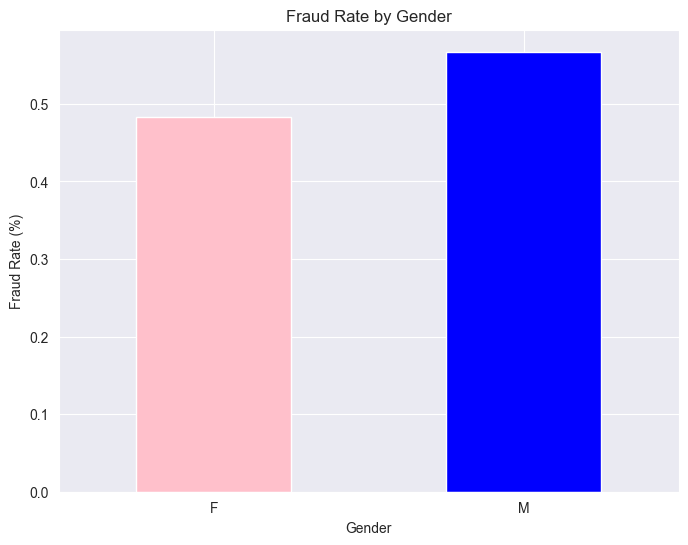

In [97]:
# Calculate Fraud Rates by Gender
fraud_rates_by_gender = data.groupby('sex')['is_fraud'].mean() * 100


plt.figure(figsize=(8, 6))
fraud_rates_by_gender.plot(kind='bar', color=['pink', 'blue'])
plt.xlabel('Gender')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Gender')
plt.xticks(rotation=0)
plt.show()

Reference: https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

In [98]:
from scipy.stats import chi2_contingency

contingency_table = data.groupby('sex')['is_fraud'].value_counts().unstack().fillna(0)

# Perform chi-square test
stat, p, dof, expected = chi2_contingency(contingency_table)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 1.97369744724312e-15
Dependent (reject H0)


Given that the p-value << alpha, we can conclude with high confidence that there is a statistically significant association between gender and the incidence of fraudulent transactions. 'sex' should be transformed to binary and be added as a feature in our model.

 # Q13. Are certain merchants susceptible to fraudulent transactions?
 

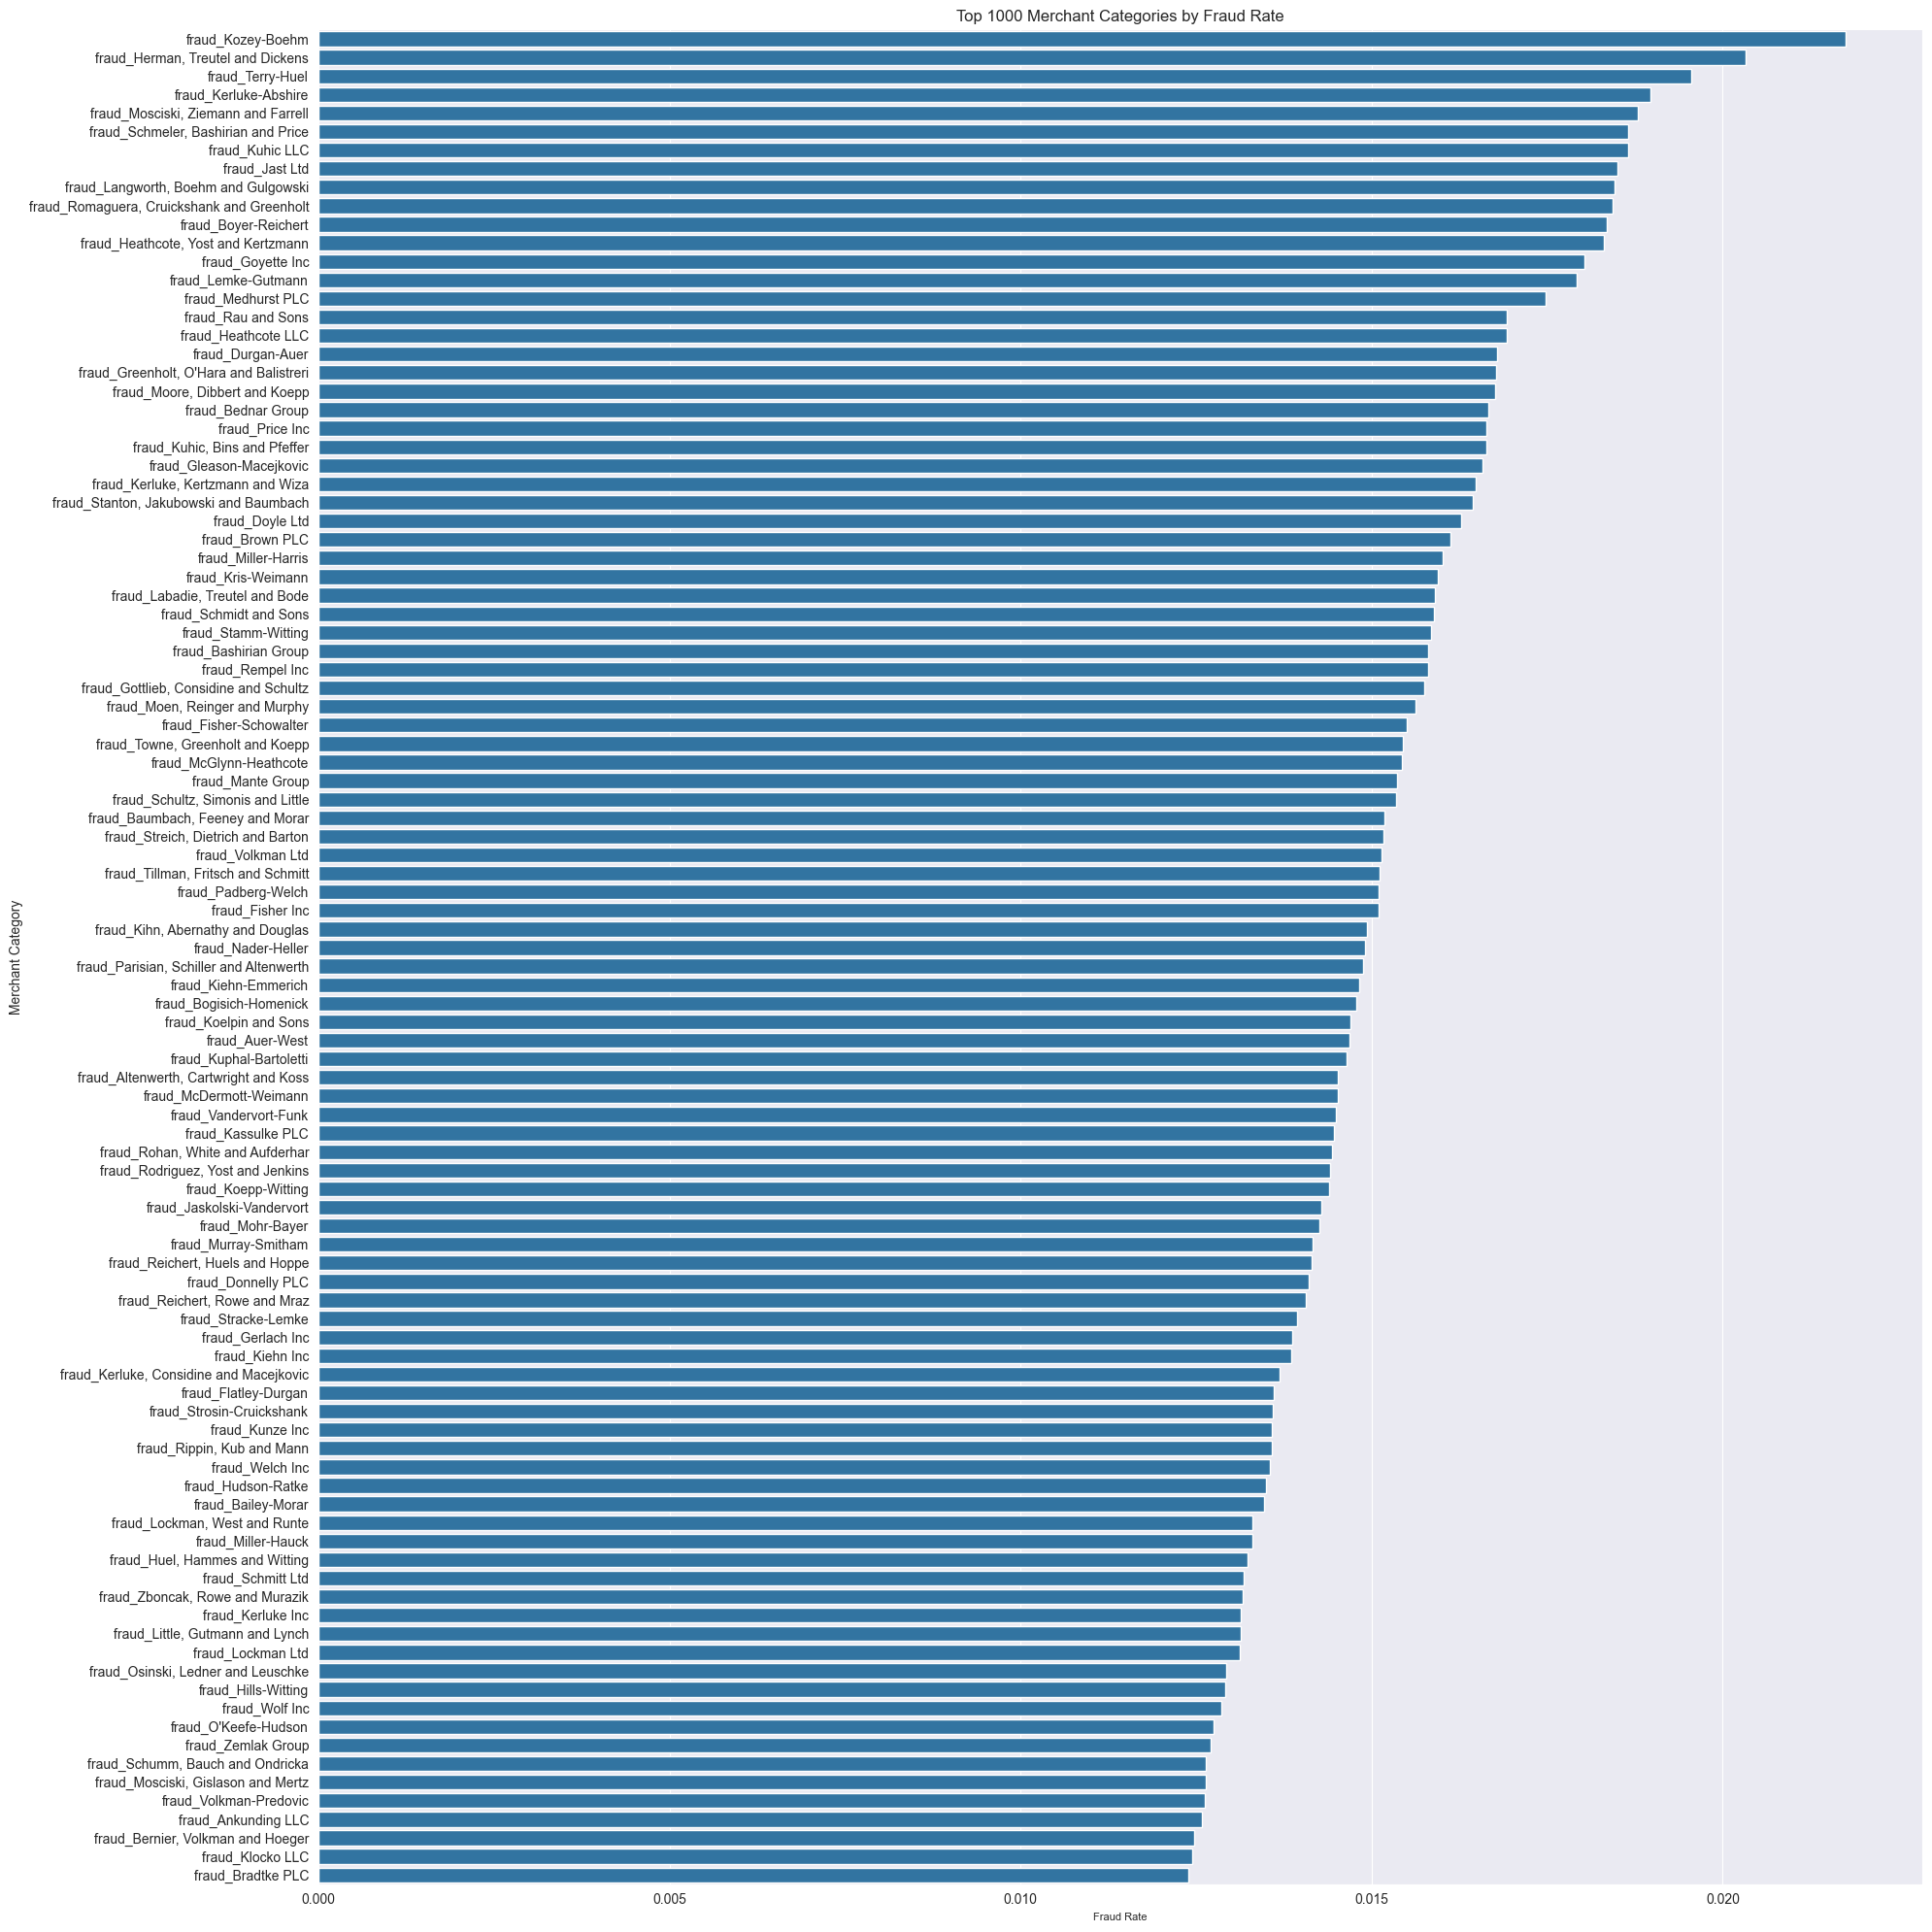

In [99]:
# Calculate the number of fraudulent transactions for each merchant
fraud_counts = data.groupby('merchant')['is_fraud'].sum()

# Calculate the total number of transactions for each merchant
total_counts = data.groupby('merchant')['is_fraud'].count()

# Step 2: Calculate Fraud Rate and convert to DataFrame 
fraud_rate = fraud_counts / total_counts
fraud_rate_df = fraud_rate.reset_index(name='fraud_rate')

#Sort Data by Fraud Rate
fraud_rate_df = fraud_rate_df.sort_values(by='fraud_rate', ascending=False)


# Plotting
plt.figure(figsize=(20, 20))
sns.barplot(x='fraud_rate', y='merchant', data=fraud_rate_df.head(100))
plt.xlabel('Fraud Rate', fontsize= 8)
plt.ylabel('Merchant Category', fontsize=10) 
plt.title('Top 1000 Merchant Categories by Fraud Rate', fontsize=12) 
plt.tight_layout()
plt.show()


In [100]:
data['merchant'].nunique()

693

Certain merchants are susceptible to fraudulent transactions. To include 'merchant' in our model we can label encode instead of one hot encoding to avoid the increase in dimensionality.

 # Q14. Is unix time the same as trans_date_trans_time?

References: https://note.nkmk.me/en/python-unix-time-datetime/

In [102]:
# Convert unix_time to datetime format
data['unix_time_s'] = pd.to_datetime(data['unix_time'], unit='s', origin='unix')

print(data[['unix_time_s', 'trans_date_trans_time']].head(10))


          unix_time_s trans_date_trans_time
0 2012-01-01 00:00:18   2019-01-01 00:00:18
1 2012-01-01 00:00:44   2019-01-01 00:00:44
2 2012-01-01 00:00:51   2019-01-01 00:00:51
3 2012-01-01 00:01:16   2019-01-01 00:01:16
4 2012-01-01 00:03:06   2019-01-01 00:03:06
5 2012-01-01 00:04:08   2019-01-01 00:04:08
6 2012-01-01 00:04:42   2019-01-01 00:04:42
7 2012-01-01 00:05:08   2019-01-01 00:05:08
8 2012-01-01 00:05:18   2019-01-01 00:05:18
9 2012-01-01 00:06:01   2019-01-01 00:06:01


When comparing the converted unix time to trans_date_trans_time, we can see that the time, day,and month are the same but not the year. Given that the transactions occurred from 2019-01-01 to 2020-12-31, we can assume that 'trans_date_trans_time' correctly reflects the transaction dates. The discrepancy suggest that there may have been an error in converting 'unix_time'. Nevertheless, we can convert 'trans_date_trans_time' to unix if we want to include it as a feature to our model as features cannot be datetime objects.

# Q15: Is there a relationship between unix_time and fraudulent transactions

In [103]:
X = sm.add_constant(data[['unix_time']])
y = data['is_fraud']

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the regression model
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.032497
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:              1852394
Model:                          Logit   Df Residuals:                  1852392
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                0.002732
Time:                        22:54:27   Log-Likelihood:                -60198.
converged:                       True   LL-Null:                       -60363.
Covariance Type:            nonrobust   LLR p-value:                 1.053e-73
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6257      0.767     11.250      0.000       7.123      10.128
unix_time  -1.023e-08   5.66

The coefficient for unix_time is approximately -1.023e-08 with a highly significant p-value (close to 0). This suggests that there is a statistically significant relationship between unix_time and the likelihood of fraud. The negative coefficient indicates that as unix_time increases (moving forward in time), the log odds of a transaction being fraudulent slightly decrease. However, the low Pseudo R-squared value indicates that unix_time explains a very small portion of the variance in fraud occurrences.

For our model, we can keep unix_time instead of transforming 'trans_date_trans_time' to unix.